In [16]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from sklearn import metrics
from skimage import measure
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

# DRAWING CONTOURS AND FINDING FEATURES OF EACH REGION OF CONTOUR USING REGIONPROPS 

In [2]:
def feature_extraction(ppi,OI,GI):
    
    _,contours,_=cv2.findContours(ppi,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    labeled_image=cv2.drawContours(GI, contours, -1, (0,255,0), 3)
    features=measure.regionprops(labeled_image,GI,cache=True)
    return features,labeled_image

# PRE PROCESSING INPUT IMAGE

In [3]:
def pre_process(img):
    
    #Otsu thresholding with binary inversion after applying Gussian Blur filter
    blur = cv2.medianBlur(img,5)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    #erosion and dilation , they are optional , may be used to decrease the unwanted object detection in image 
    #if we know the kind of image we are dealing 
    #for generalised purpose we may not use them as sometimes might give less accuracy
    kernel = np.ones((5,5),np.uint8)
    #th = cv2.dilate(th,kernel,iterations = 1)
    #th = cv2.erode(th,kernel,iterations = 3)
    return th


# INPUT IMAGE TO DETECT HINDI LANGUAGE

In [34]:
#import image with cv2 , 0 implies image is read as black&white / gray
Image=cv2.imread(r'sample/hindi_1.jpg')
Gray_Image=cv2.cvtColor(Image, cv2.COLOR_BGR2GRAY)
#image sent to preprocessing
pre_processed_img=pre_process(Gray_Image)

Region_Prop,Labeled_Image=feature_extraction(pre_processed_img,Image,Gray_Image)



# DRAWING INPUT IMAGE WITH DETECTED TEXT REGION USING CONTOURS

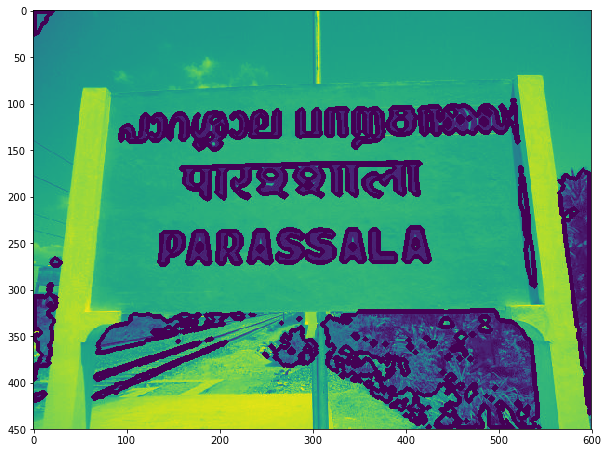

In [35]:
plt.figure(figsize=(10,10))
plt.imshow(Labeled_Image)
plt.show()

# Find Features of Input Image

In [36]:
Input_Image_Features=[]

for i in Region_Prop:
    Convex_area=i.convex_area
    Eccentricity=i.eccentricity
    Euler_number=i.euler_number
    Inertia_tensor_eigval=list(i.inertia_tensor_eigvals)
    Moments_hu=list(i.moments_hu)
    Solidity=i.solidity
    Weighted_moments_hu=list(i.weighted_moments_hu)
    Input_Image_Features.append([Convex_area,Eccentricity,Euler_number,Inertia_tensor_eigval[0],Inertia_tensor_eigval[1],Moments_hu[0],Moments_hu[1],Moments_hu[2],Solidity, Weighted_moments_hu[0], Weighted_moments_hu[1], Weighted_moments_hu[2]])

# Import the csv Data we Made using sample images to train randomforestclassifier

In [37]:
columns=['Convex_area','Eccentricity','Euler_number','Inertia_tensor_eigval-1','Inertia_tensor_eigval-2','Moments_hu-1','Moments_hu-2','Moments_hu-3','Solidity','Weighted_moments_hu-1','Weighted_moments_hu-2','Weighted_moments_hu-3','Type']
Dataset=pd.read_csv(r'Image_Data.csv',names=columns)
Dataset.head()

,Convex_area,Eccentricity,Euler_number,Inertia_tensor_eigval-1,Inertia_tensor_eigval-2,Moments_hu-1,Moments_hu-2,Moments_hu-3,Solidity,Weighted_moments_hu-1,Weighted_moments_hu-2,Weighted_moments_hu-3,Type
0,1,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
1,1,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,1,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
3,1,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
4,1,0.0,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


# Split the Dataset into  features and targets

In [38]:
Dataset_Features=[]
Dataset_Targets=[]

for a,b,c,d,e,f,g,h,i,j,k,l,m in zip(Dataset['Convex_area'],Dataset['Eccentricity'],Dataset['Euler_number'],
                                     Dataset['Inertia_tensor_eigval-1'],Dataset['Inertia_tensor_eigval-2'],
                                     Dataset['Moments_hu-1'],Dataset['Moments_hu-2'],Dataset['Moments_hu-3'],
                                     Dataset['Solidity'],Dataset['Weighted_moments_hu-1'],Dataset['Weighted_moments_hu-1'],
                                    Dataset['Weighted_moments_hu-1'],Dataset['Type']):
    
    Dataset_Features.append([a,b,c,d,e,f,g,h,i,j,k,l])
    Dataset_Targets.append(m)

# Split data into test-train to find accuracy later on

In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(Dataset_Features, Dataset_Targets, test_size = 0.3)

# Creating a RandomForrestClassifier

In [40]:
RFC = RandomForestClassifier()
RFC.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Predict Wheather Input Image has Hindi Language

In [45]:
Predict_Input_Image=RFC.predict(Input_Image_Features)

if 1 in Predict_Input_Image and 0 not in Predict_Input_Image:
    print("Only Hindi Language Detected")

elif 1 in Predict_Input_Image and 0 in Predict_Input_Image:
    print("Both Hindi And Non-Hindi Language Detected")

elif 1 not in Predict_Input_Image and 0  in Predict_Input_Image:
    print("Only Non Hindi Language Detected")


Both Hindi And Non-Hindi Language Detected


# Find the accuracy of the model 

In [42]:
Predict_Values_Test=RFC.predict(X_test)
Accuracy=metrics.accuracy_score(Y_test,Predict_Values_Test)
print(Accuracy*100)

94.1202203431
